In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from scipy.stats import norm,skew

In [3]:
winedata=pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

winedata.replace([np.inf, -np.inf], np.nan, inplace=True)

winedata.dropna(inplace=True)

In [4]:
winedata.info()
print("The dimensions of the data are",winedata.shape)
winedata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
The dimensions of the data are (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
#print(winedata.head())
winedata.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


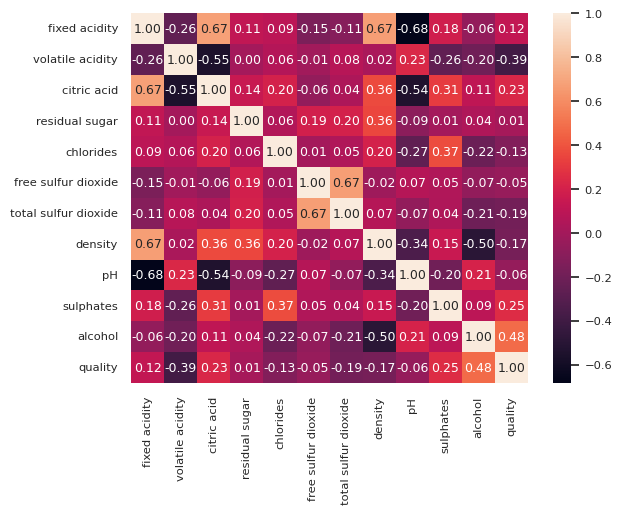

In [6]:
correlation=winedata.corr()
#correlation_val=np.corrcoef(wine_data_new.values.T)
#print(correlation_val)
sns.set(font_scale=0.75)
hm = sns.heatmap(correlation,annot=True,fmt='.2f',)
plt.show()

fixed acidity seems to be highly correlated with citric acid and density. There might be multi-collinearity here and we can drop fixed acidity (citric acidity seems to have a larger correlation with the quality whereas density has the opp. correlation). But I might just keep everything here for now.

Also total and free sulfur di oxide have high correlation. whereas pH, residual sugar and free sulfur di oxide have no effect on the final quality.

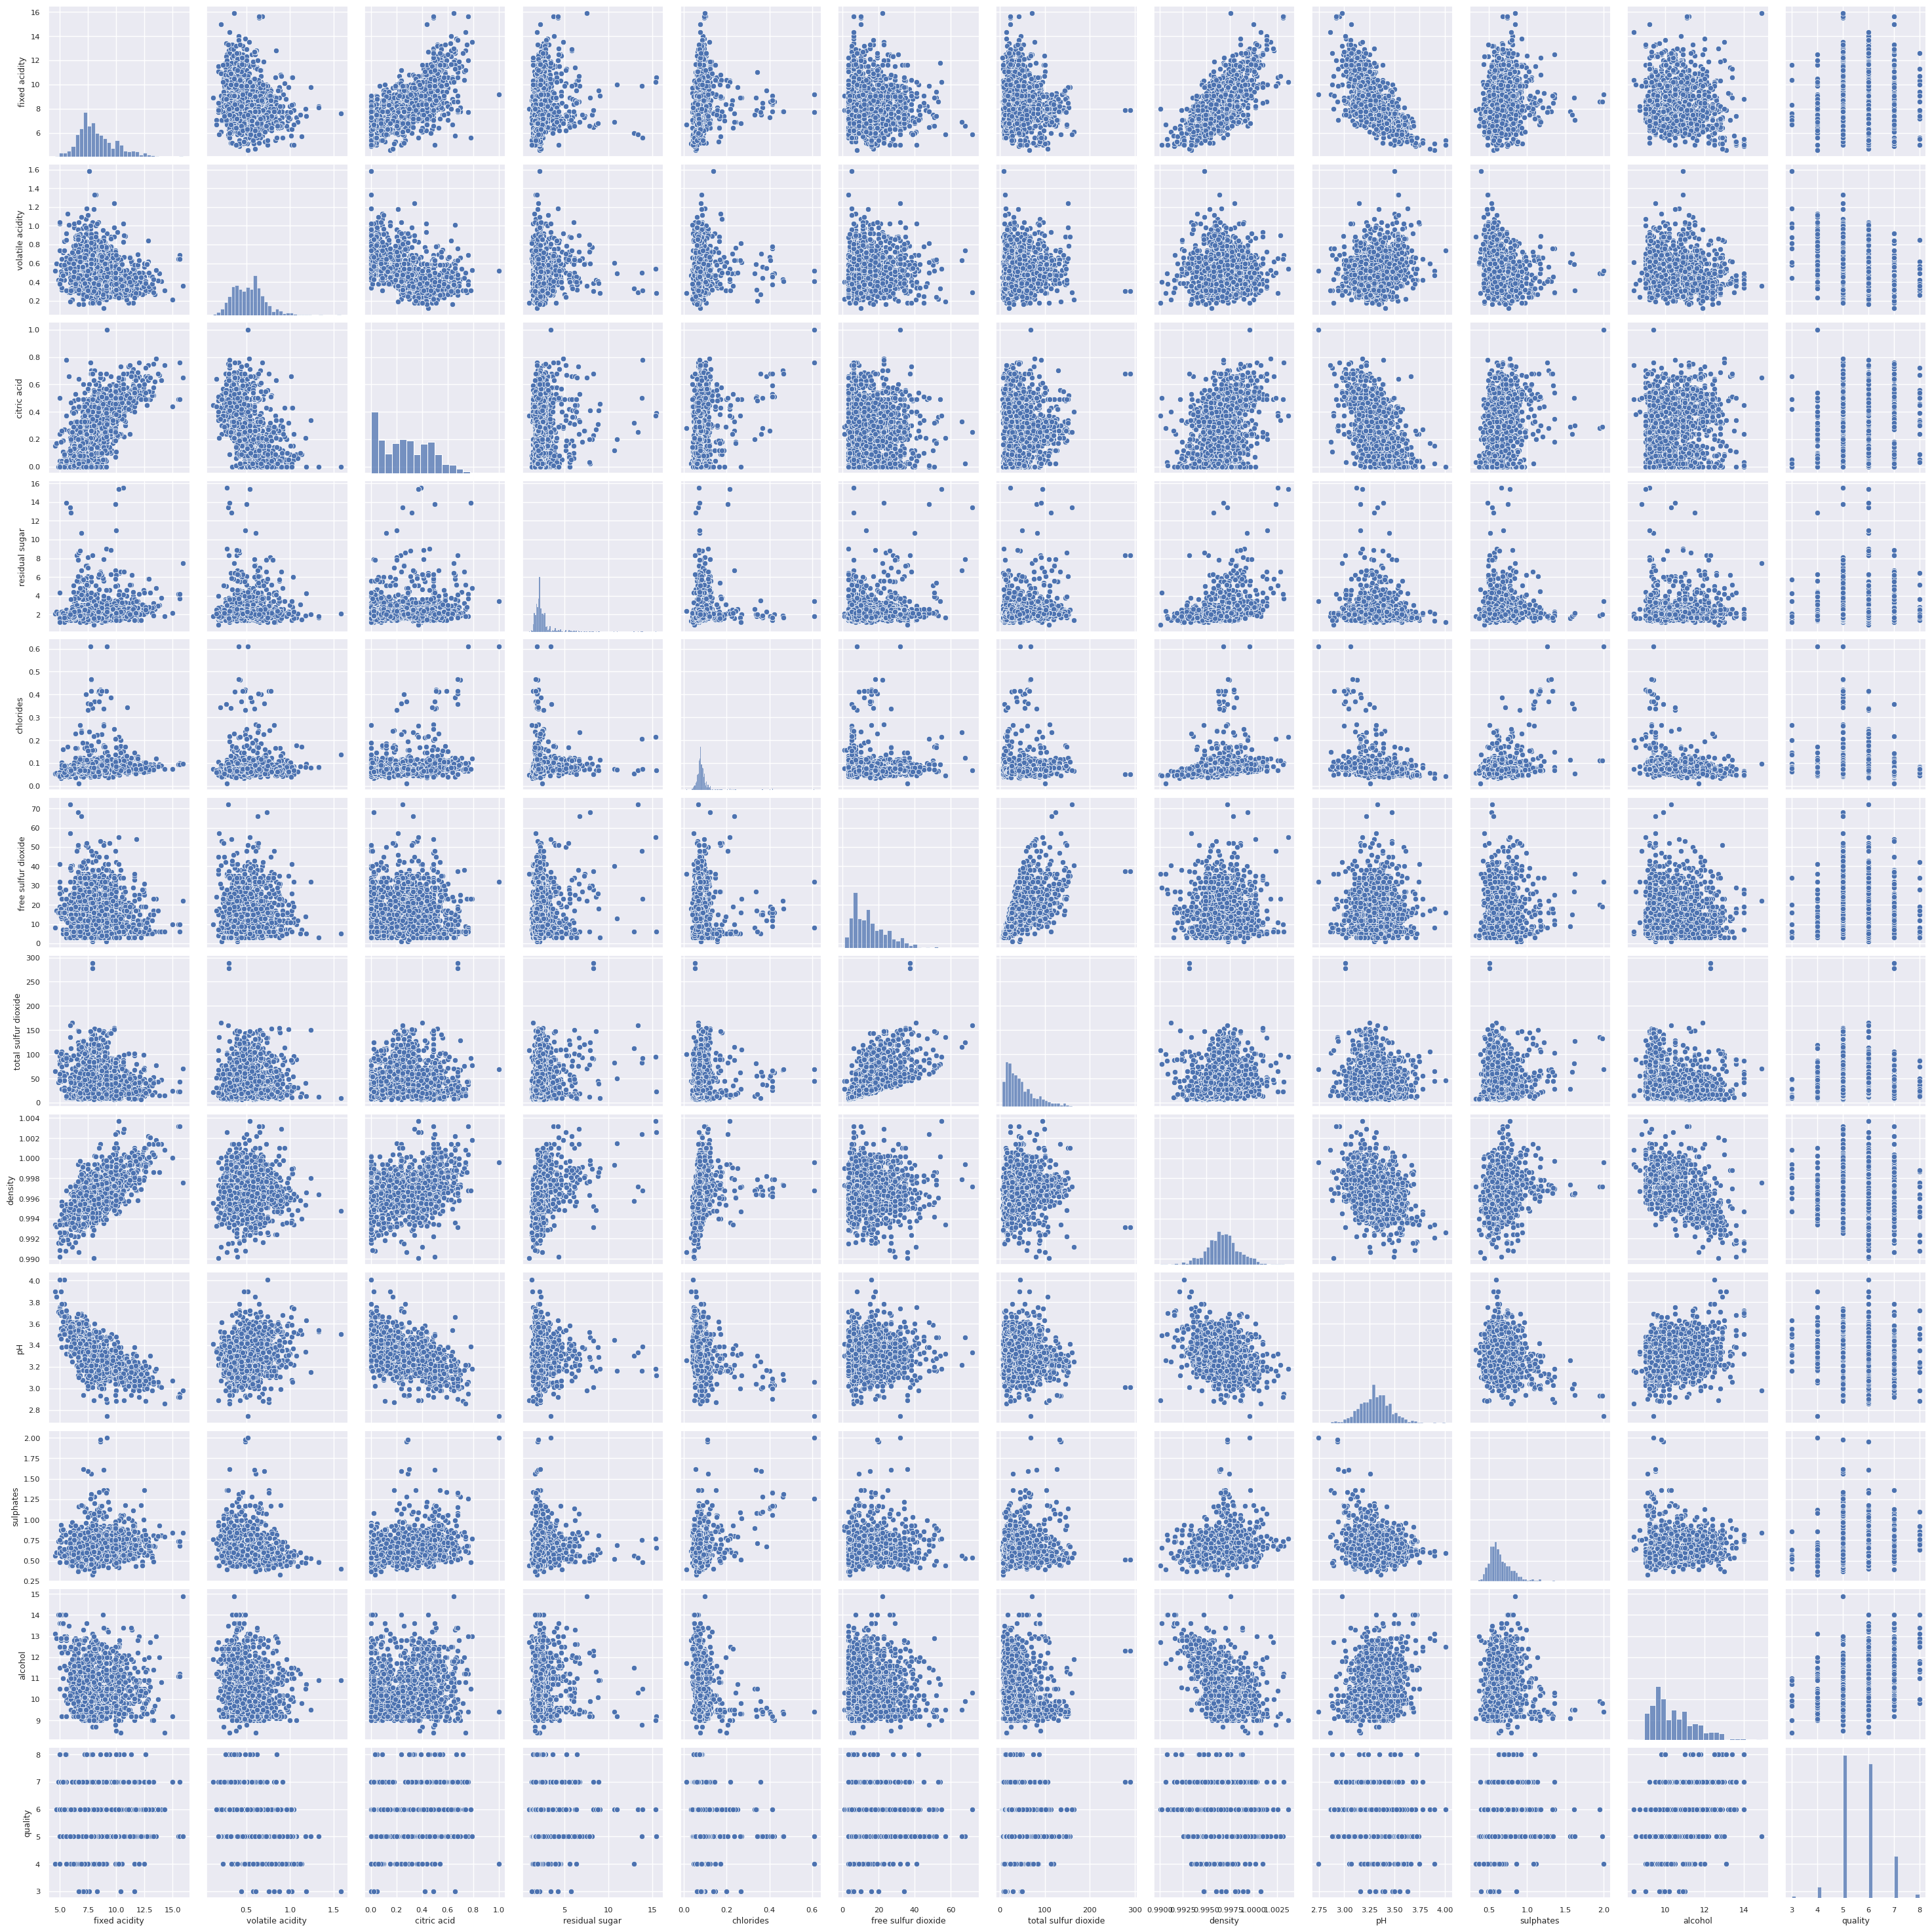

In [7]:
sns.pairplot(winedata)

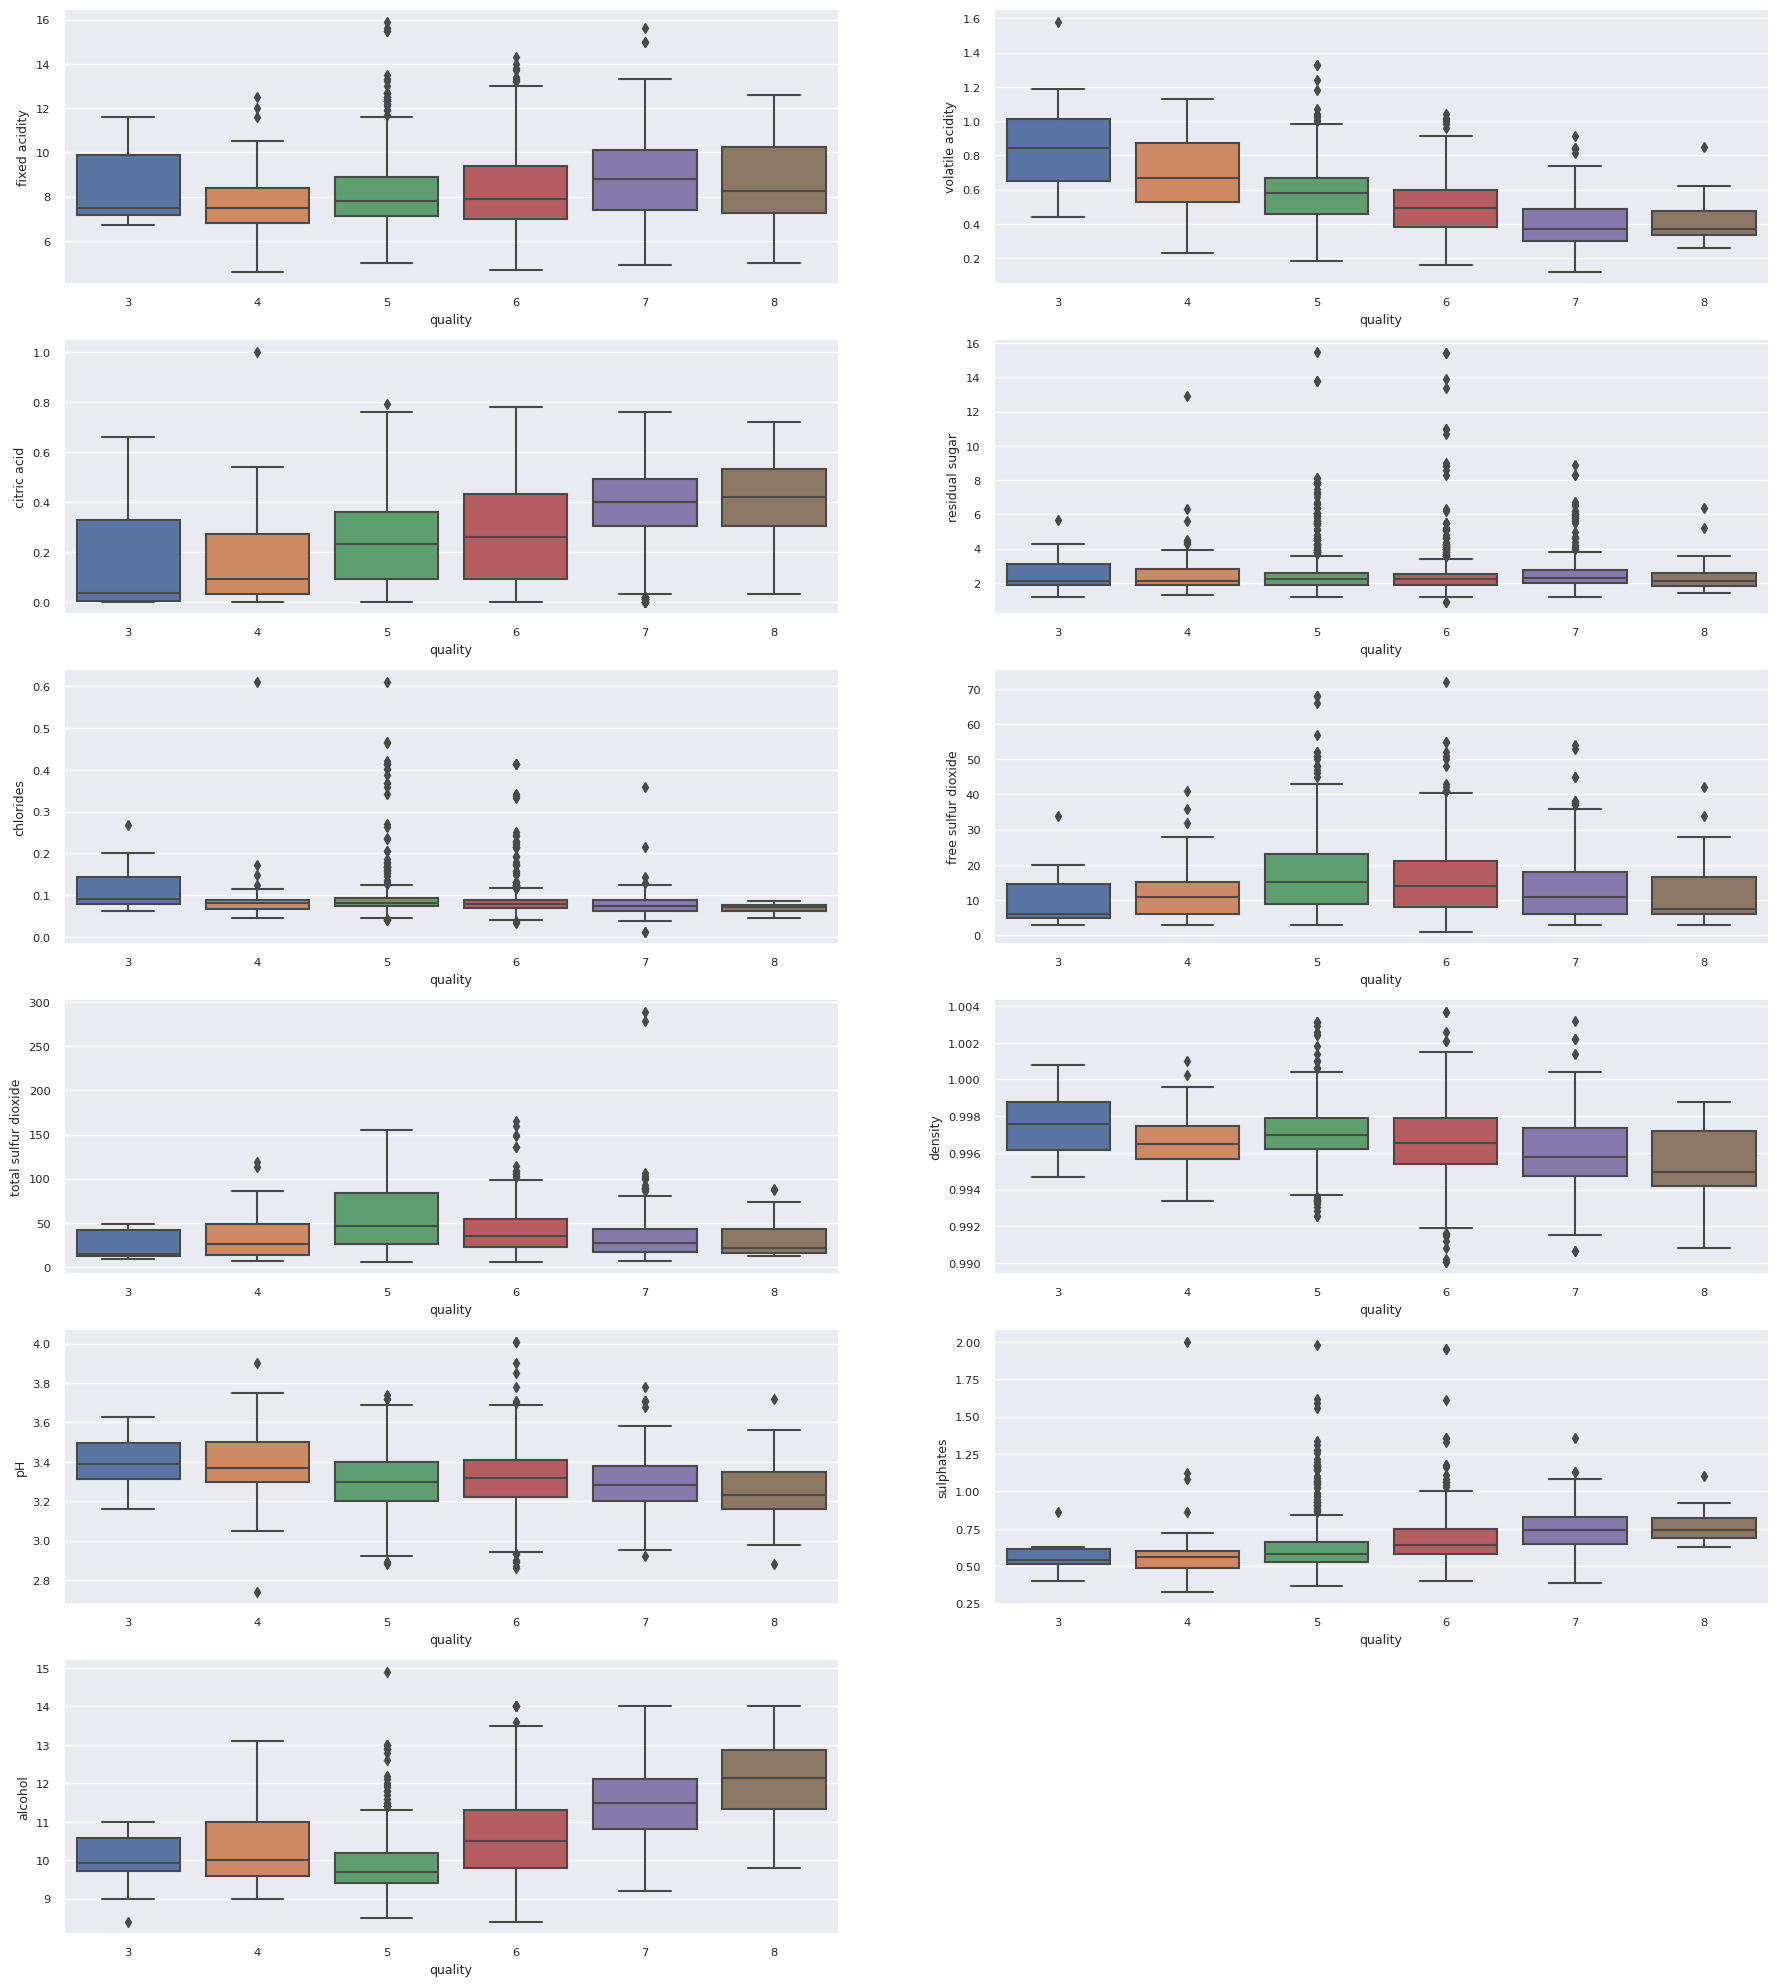

In [8]:
cols=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',

           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',

           'pH', 'sulphates', 'alcohol']

plt.figure(figsize=(22,25))

for i in range(len(cols)):

    plt.subplot(6,2,i+1)
    
    sns.boxplot(x="quality",y=cols[i],data=winedata)
    
plt.show()

In [9]:
wine_data=winedata

for qual in range(3,9):

    for col in cols:
        
        q1 = wine_data.loc[wine_data["quality"]==qual,col].quantile(0.25)
        q3 = wine_data.loc[wine_data["quality"]==qual,col].quantile(0.75)
        
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        med = np.median(wine_data.loc[wine_data["quality"]==qual,col])
        
        for i in wine_data.loc[wine_data["quality"]==qual,col]:
              if i > Upper_tail or i < Lower_tail:
                     wine_data.loc[wine_data["quality"]==qual,[col]] = wine_data.loc[wine_data["quality"]==qual,[col]].replace(i, med)

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.00000,1599.000000,1599.000000,1599.000000
mean,8.183240,0.519912,0.274228,2.186335,0.079010,14.914321,44.652908,0.996729,3.30945,0.632830,10.368684,5.636023
std,1.540499,0.166660,0.192083,0.429894,0.015114,8.878729,30.478366,0.001662,0.14081,0.117733,1.019069,0.807569
min,4.600000,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,0.990800,2.92000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995685,3.21000,0.550000,9.500000,5.000000
50%,7.800000,0.520000,0.260000,2.200000,0.078000,13.000000,36.000000,0.996750,3.31000,0.610000,10.100000,6.000000
75%,9.050000,0.630000,0.420000,2.400000,0.087000,20.000000,60.000000,0.997800,3.40000,0.700000,11.000000,6.000000
max,13.300000,1.185000,0.780000,4.250000,0.200000,43.000000,155.000000,1.001500,3.75000,1.080000,14.000000,8.000000


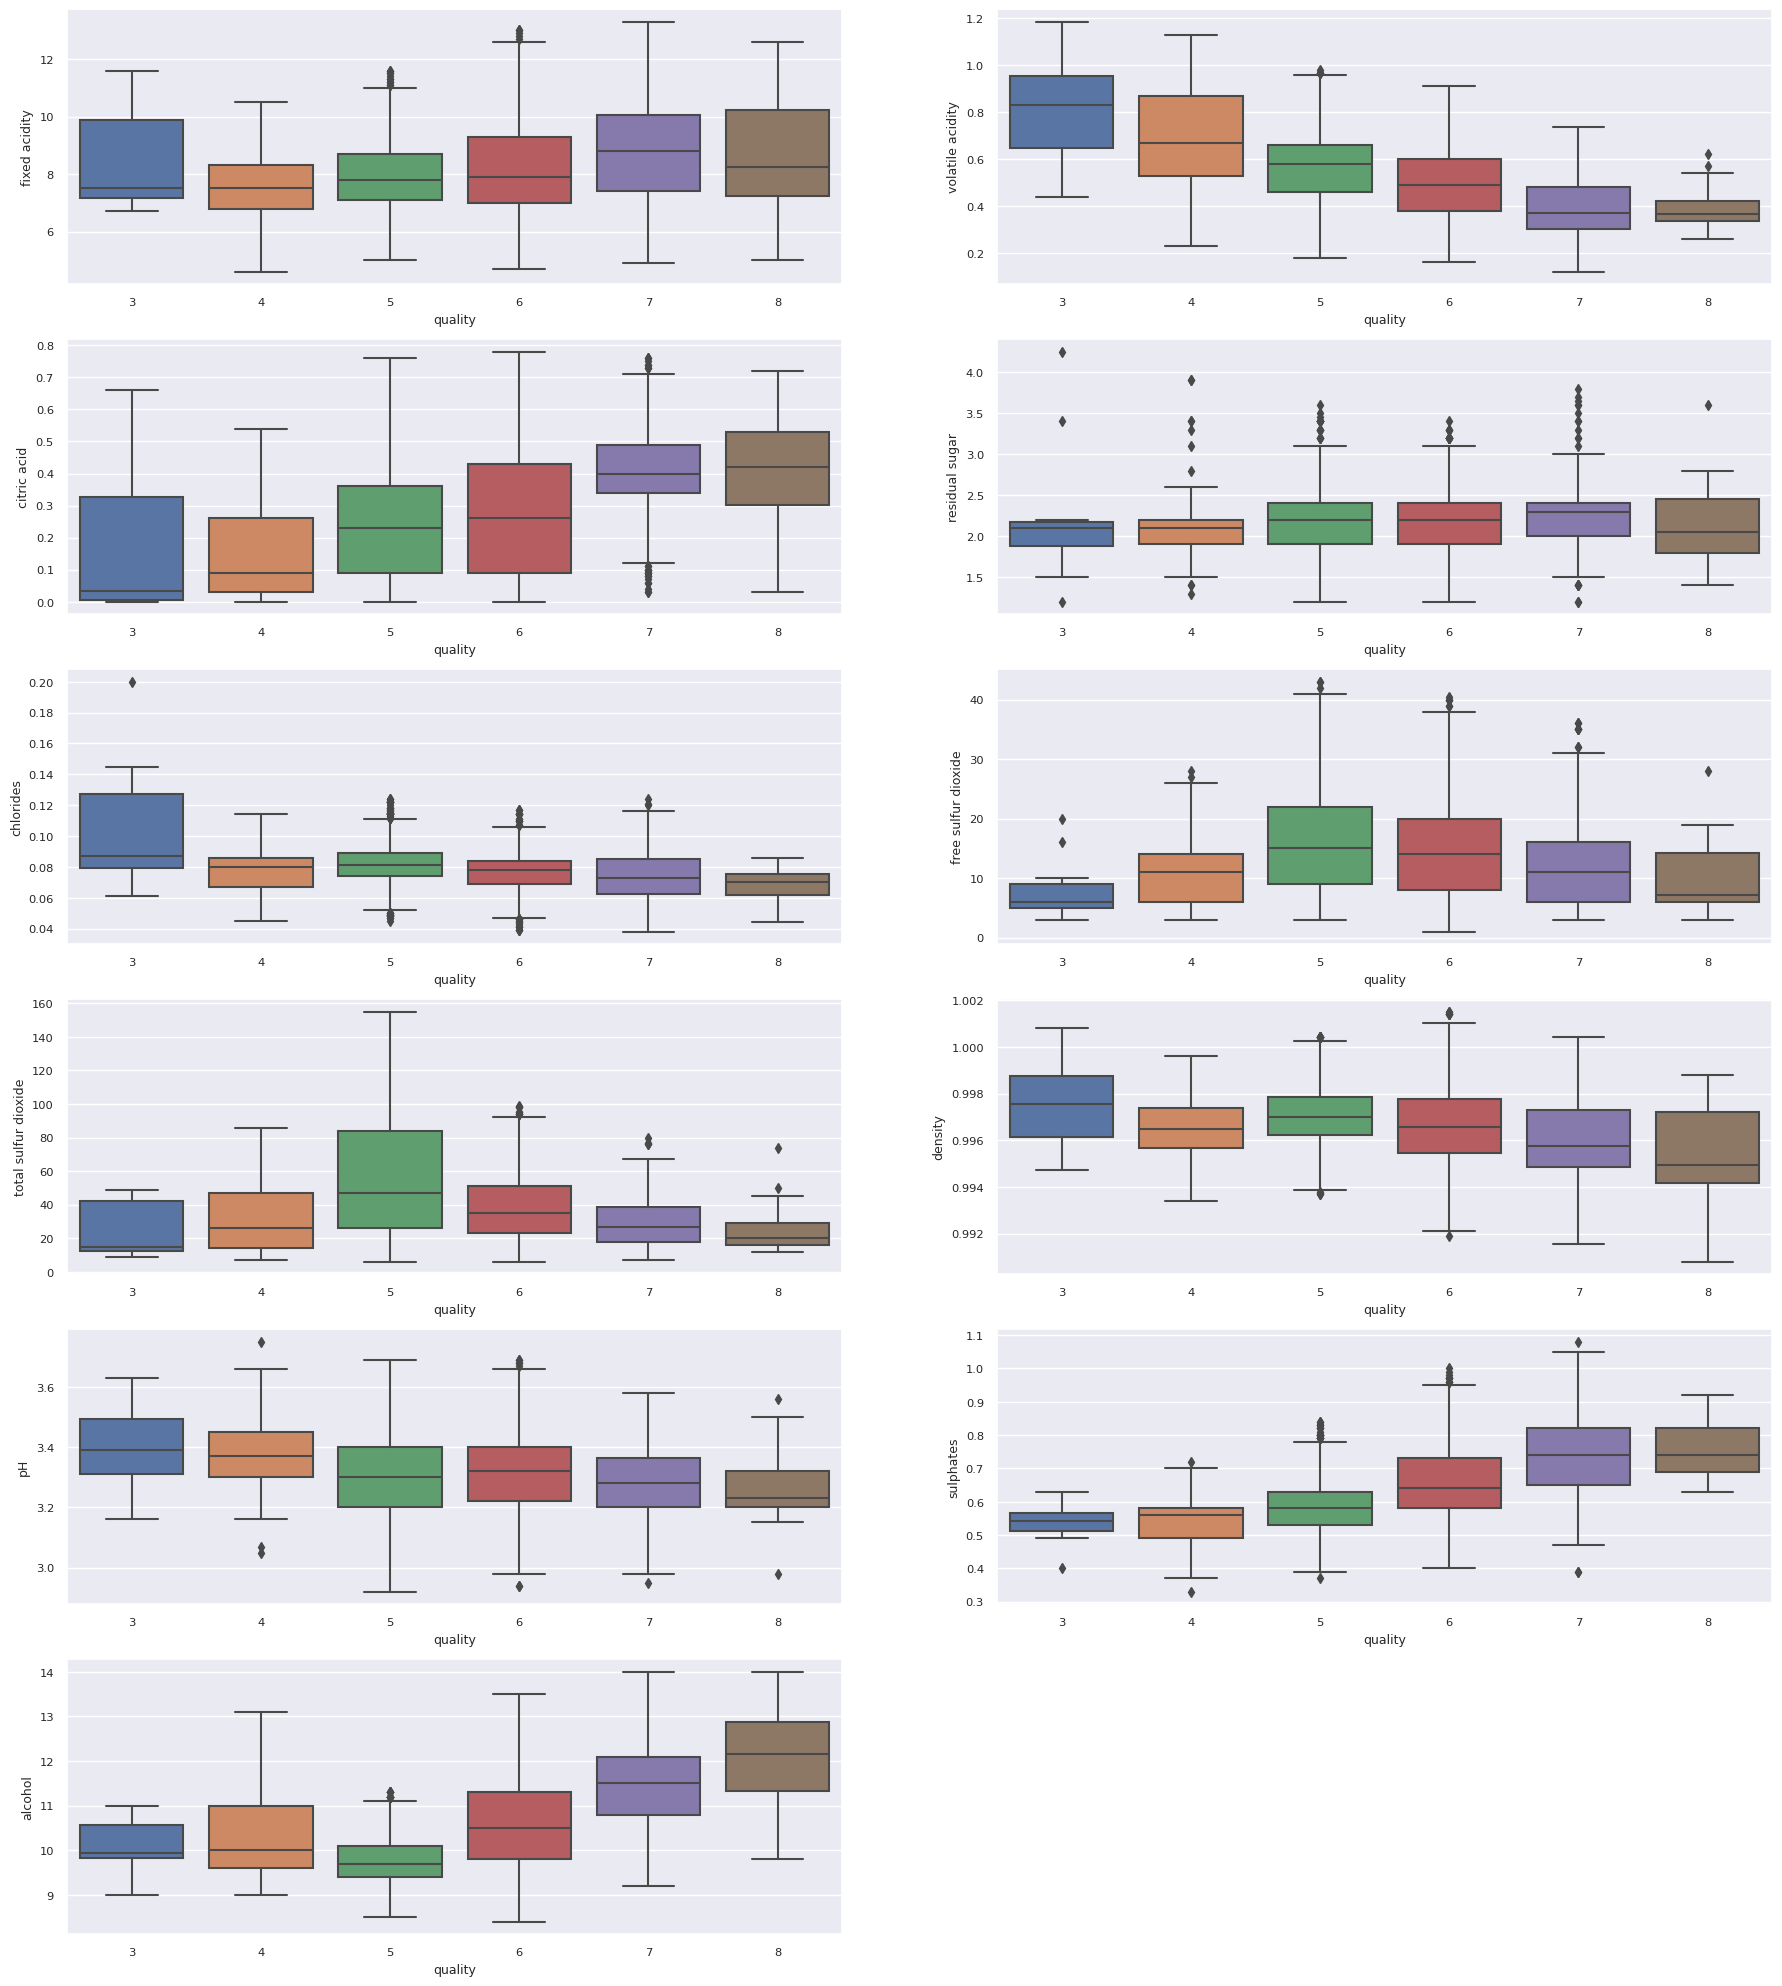

In [10]:
plt.figure(figsize=(22,25))

for i in range(len(cols)):

    plt.subplot(6,2,i+1)
    
    sns.boxplot(x="quality",y=cols[i],data=wine_data)
    
plt.show()

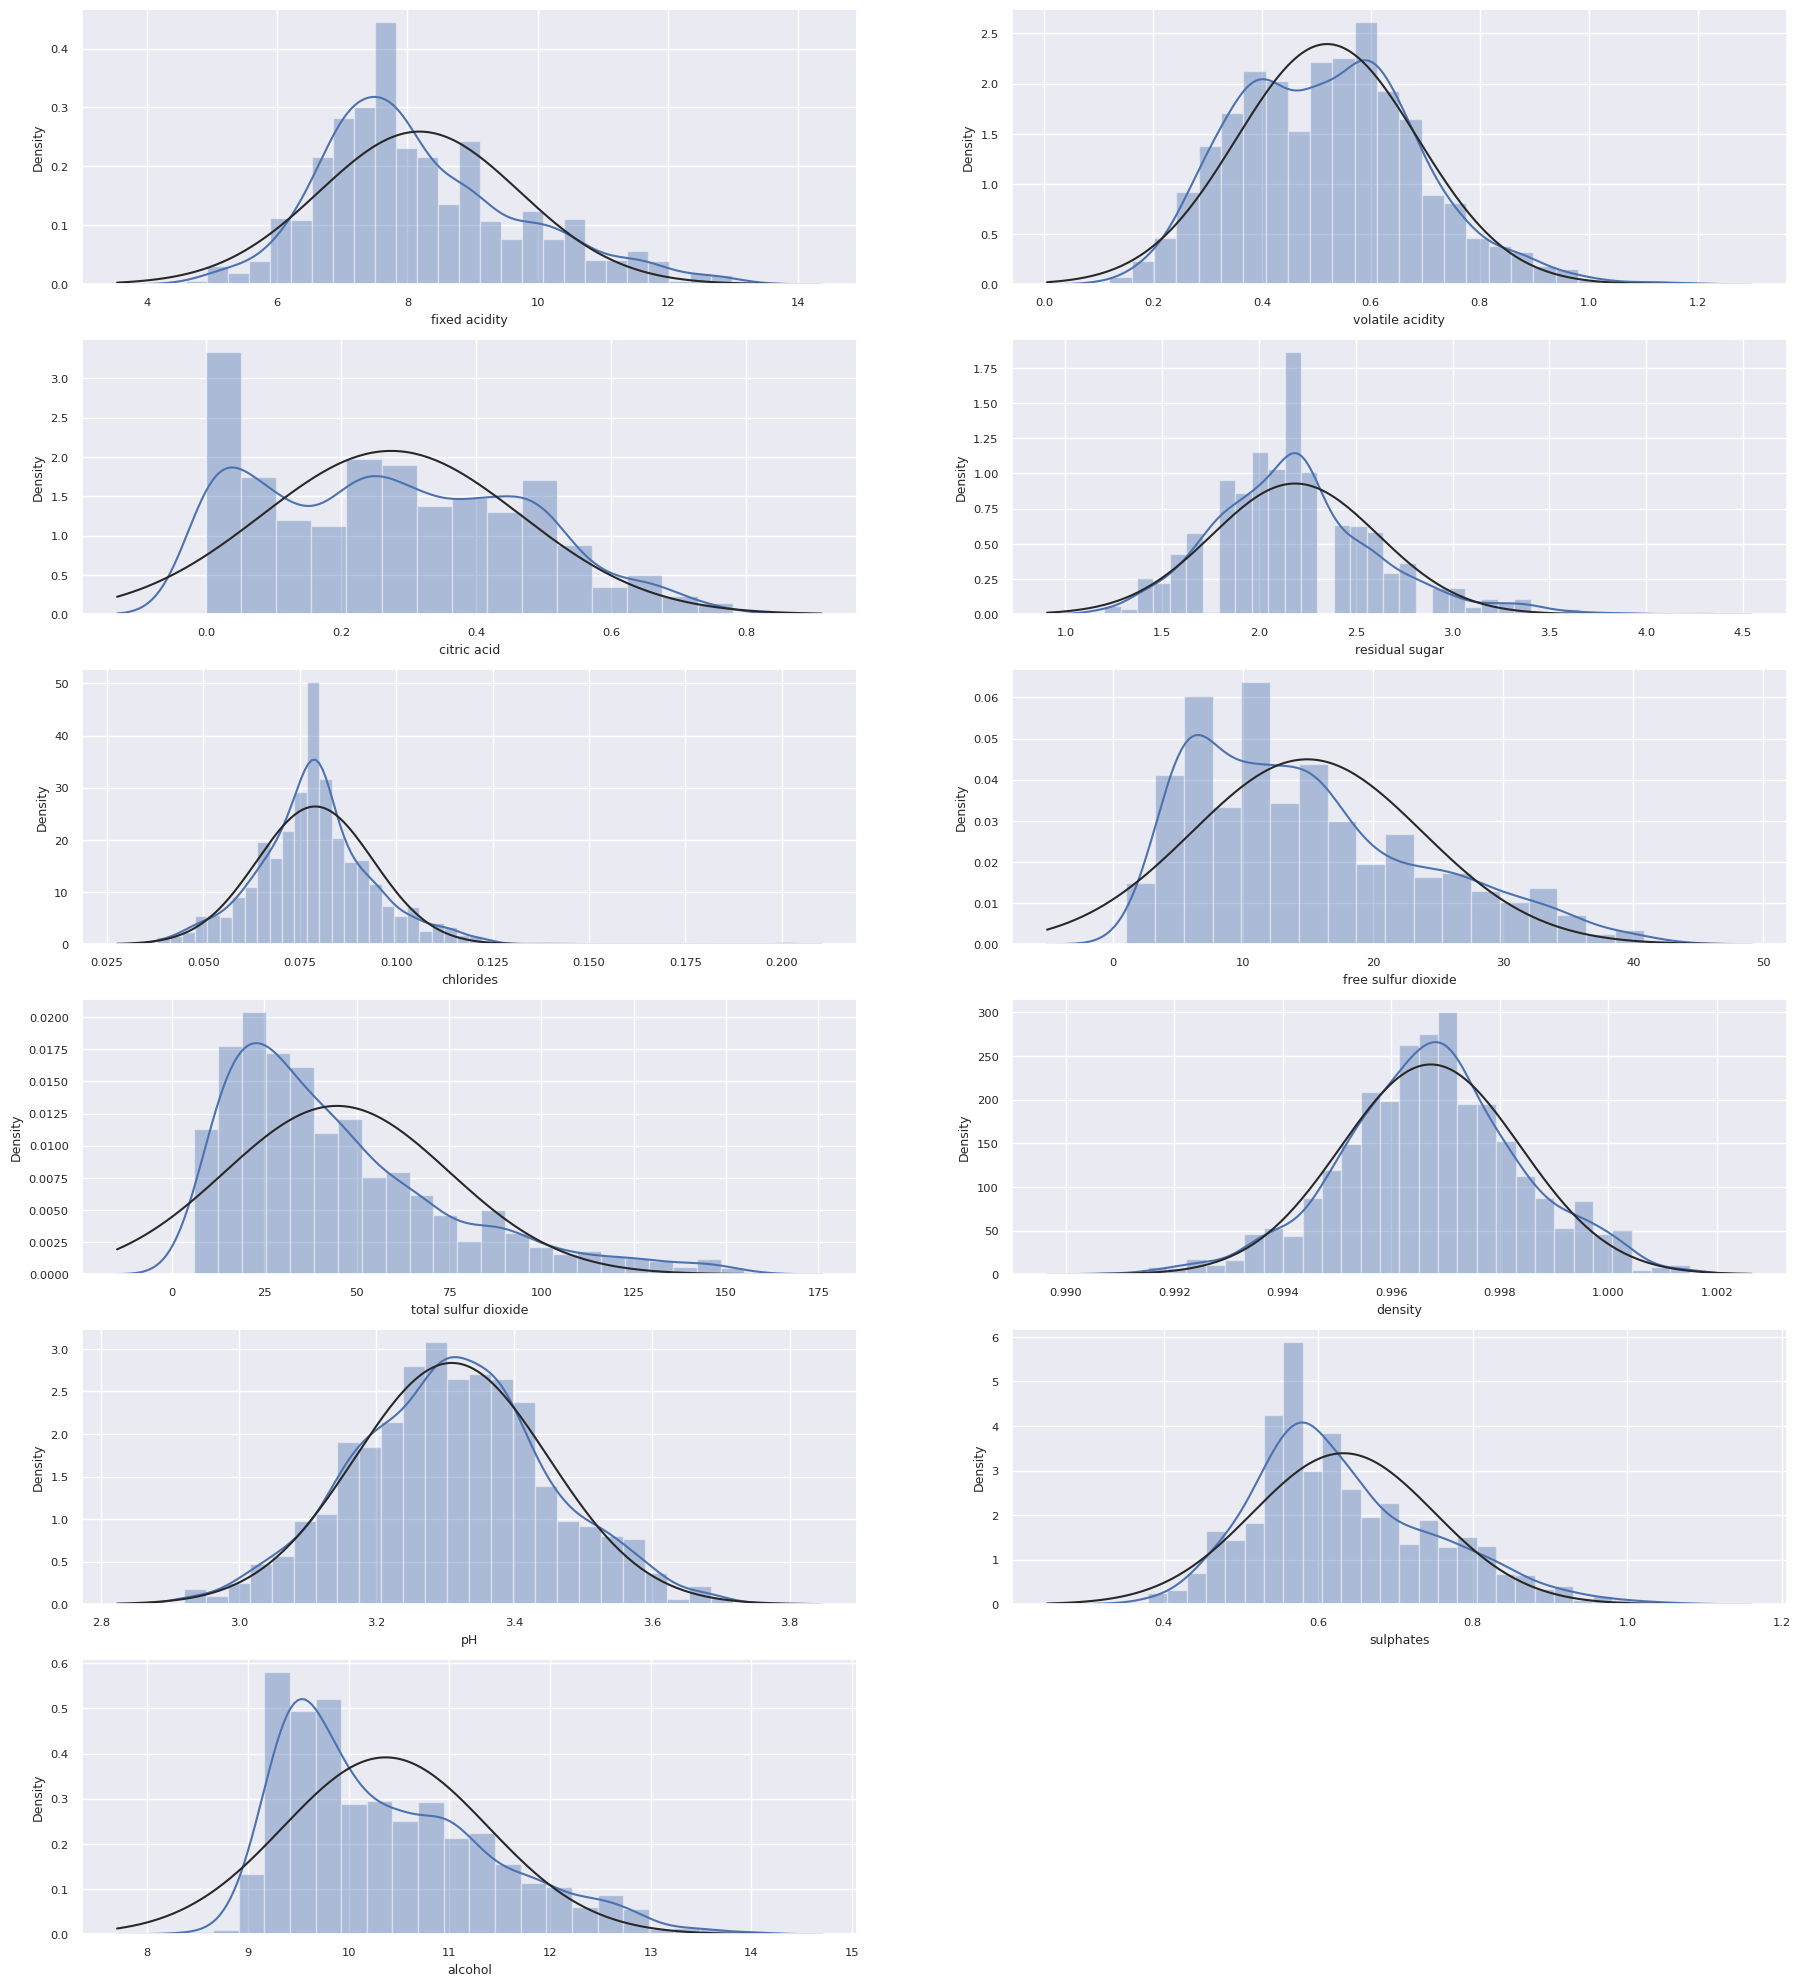

In [11]:
cols=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',

           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',

           'pH', 'sulphates', 'alcohol']

plt.figure(figsize=(22,25))

for i in range(len(cols)):
    
    plt.subplot(6,2,i+1)
    
    sns.distplot(wine_data[cols[i]],fit=norm)
    

plt.show()

In [ ]:
#for row in wine_data["citric acid"]:
#    if row==0:
#        wine_data["citric acid"] = wine_data["citric acid"].replace(row,0.001)

#wine_data.describe()

In [ ]:

#plt.figure(figsize=(22,25))

#for i in range(2,3):

#    wine_data[cols[i]]=np.exp(wine_data[cols[i]])
    
#    plt.subplot(6,2,i+1)

#    sns.distplot(winedata[cols[i]],fit=norm)
    
#plt.show()

In [15]:
reviews=[]

for i in wine_data['quality']:
    if i<=5:
        reviews.append("Bad")
    elif i>5 and i<7:
        reviews.append("Average")
    else:
        reviews.append("Good")

wine_data["reviews"]=reviews

wine_data['reviews'].value_counts()

reviews
Bad        744
Average    638
Good       217
Name: count, dtype: int64

In [29]:
X=wine_data.drop(["quality",'reviews'],axis=1)
Y=wine_data.reviews

Xtrain,Xtest,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(Xtrain)
X_test=scaler.fit_transform(Xtest)

In [ ]:
#from sklearn.decomposition import PCA
#pca = PCA()
#X_pca = pca.fit_transform(X)

#plt.figure(figsize=(10,10))
#plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
#plt.grid()

Training accuracy :0.640%n
Test accuracy : 0.618%n
              precision    recall  f1-score   support

     Average       0.54      0.69      0.60       169
         Bad       0.73      0.70      0.71       178
        Good       0.55      0.11      0.19        53

    accuracy                           0.62       400
   macro avg       0.60      0.50      0.50       400
weighted avg       0.62      0.62      0.60       400



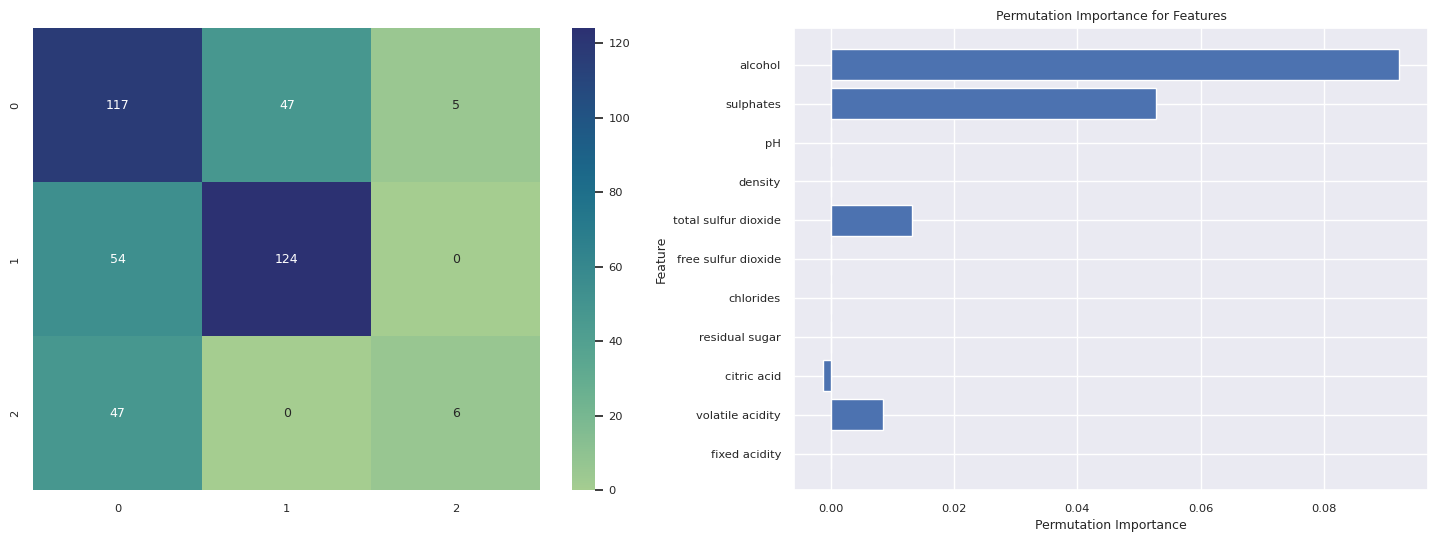

In [32]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models={
        LogisticRegression(C=0.1,penalty = 'l1', solver='saga',max_iter=5000)
        #,RandomForestClassifier(criterion = 'gini',max_depth = 20, max_features ='sqrt', n_estimators = 100,random_state = 33)
        #,KNeighborsClassifier(algorithm = 'auto',leaf_size = 400, metric = 'euclidean',n_jobs = -1, n_neighbors = 10, p = 2,weights = 'distance')
        #,DecisionTreeClassifier(criterion = 'entropy', splitter = 'best',max_features=6, max_depth = 10, max_leaf_nodes=200, random_state = 33)
}

for model in models:
     model.fit(X_train,Y_train)
     y_pred=model.predict(X_test)


    
     print("Training accuracy :{:.3f}".format(model.score(X_train,Y_train)))
    
     print("Test accuracy : {:.3f}".format(model.score(X_test,Y_test)))

     print(classification_report(Y_test, y_pred))

     


     perm_importance = permutation_importance(model, X_test, Y_test, n_repeats=10, random_state=42)

     # Extract and plot feature importances

     feature_importance = perm_importance.importances_mean

     feature_names = X.columns


     plt.figure(figsize=(18, 6))

     plt.subplot(1,2,1)

     sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True,cmap="crest",fmt='.0f')

     plt.subplot(1,2,2)

     plt.barh(feature_names, feature_importance)  # Red color for bars

     plt.xlabel('Permutation Importance')

     plt.ylabel('Feature')

     plt.title('Permutation Importance for Features')

     plt.show()

Looks like random forest classifier is the best of all them.